In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from flygym import Fly, Camera, SingleFlySimulation
from flygym.examples.obstacle_arena import ObstacleOdorArena
from flygym.arena import FlatTerrain, GappedTerrain
from flygym.preprogrammed import all_leg_dofs
from flygym.util import get_data_path, load_config

color_cycle_rgb = load_config()["color_cycle_rgb"]

In [2]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

# Load recorded data
data_path = get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [3]:
def sample_visual_data(
    sim, obstacle_positions, action, visualize=False, camera="birdeye_cam"
):
    fly = sim.fly

    # Change obstacle positions in the arena
    for i in range(obstacle_positions.shape[0]):
        pos_xyz = np.array([*obstacle_positions[i, :], sim.arena.obstacle_z_pos])
        sim.physics.bind(sim.arena.obstacle_bodies[i]).mocap_pos = pos_xyz
        sim.step(action)

    # Render visual input
    fly._last_vision_update_time = -np.inf  # hack: this forces visual input update
    fly._update_vision(sim)
    visual_input = fly._curr_visual_input.copy()
    raw_cam_imgs = fly._curr_raw_visual_input.copy()

    # Calculate obstacle positions relative to the fly
    fly_rotation = fly.spawn_orientation[2]
    rot_matrix = np.array(
        [
            [np.cos(fly_rotation), -np.sin(fly_rotation)],
            [np.sin(fly_rotation), np.cos(fly_rotation)],
        ]
    )
    obstacle_positions_transformed = obstacle_positions - fly.spawn_pos[:2]
    obstacle_positions_transformed[:, 1] *= -1  # change y to right-hand-positive
    obstacle_positions_transformed = (rot_matrix @ obstacle_positions_transformed.T).T

    # Visualize
    if visualize:
        fig, axs = plt.subplots(1, 5, figsize=(10, 5), tight_layout=True)
        birdeye_img = sim.physics.render(camera_id=camera, height=512, width=512)
        axs[0].imshow(birdeye_img)
        axs[0].axis("off")
        for i in range(2):
            axs[i + 1].imshow(raw_cam_imgs[i], cmap="gray", vmin=0, vmax=255)
            axs[i + 1].axis("off")
        for i in range(2):
            vis = fly.retina.hex_pxls_to_human_readable(
                visual_input[i].max(-1), color_8bit=True
            )
            axs[i + 3].imshow(vis, cmap="gray", vmin=0, vmax=255)
            axs[i + 3].axis("off")

    return visual_input, obstacle_positions_transformed

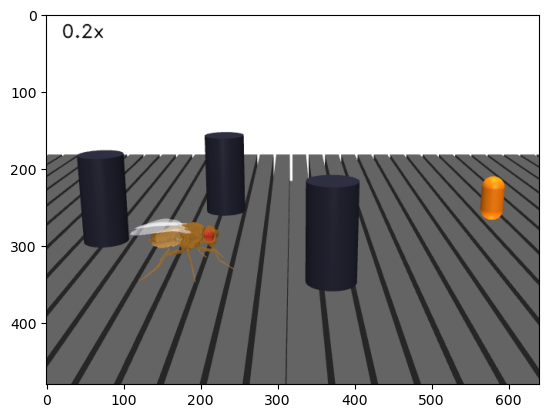

In [4]:
terrain_arena = GappedTerrain(
    x_range=(-20, 40), y_range=(-20, 20), gap_width=0.2, ground_alpha=1
)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5), (-10, -10)]),
    marker_size=0.5,
    obstacle_colors=(0.14, 0.14, 0.2, 1),
    user_camera_settings=((16, -30, 11), (np.deg2rad(75), 0, 0), 30),
)

fly = Fly(
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
    spawn_pos=(12, -4, 0.5),
    spawn_orientation=(0, 0, np.deg2rad(90)),
)

cam = Camera(
    fly=fly,
    camera_id="user_cam",
    play_speed=0.2,
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    arena=arena,
)

action = {"joints": data_block[:, 0]}
for i in range(100):
    sim.step(action)
    sim.render()

plt.imshow(cam._frames[-1])
Image.fromarray(cam._frames[-1]).save("outputs/env_schematic.png")

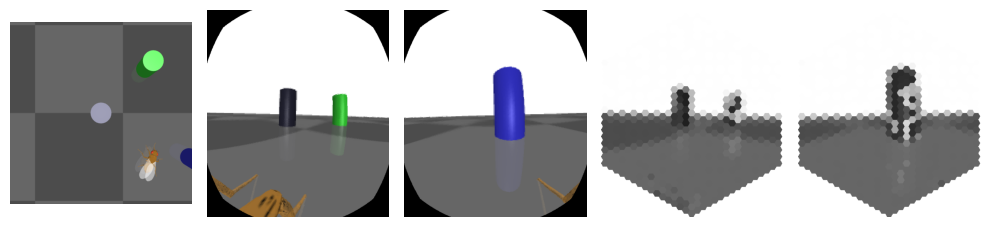

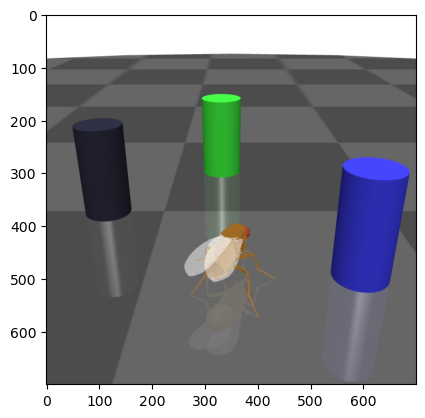

In [5]:
terrain_arena = FlatTerrain()
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, -5)]),
    marker_size=0.01,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)

fly = Fly(
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
    spawn_pos=(13, -5, 0.5),
    spawn_orientation=(0, 0, np.deg2rad(160)),
)

cam = Camera(
    fly=fly,
    play_speed=0.2,
    camera_id="user_cam",
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    arena=arena,
)

action = {"joints": data_block[:, 0]}
for i in range(100):
    sim.step(action)
    sim.render()

sample_visual_data(
    sim, np.array([(7.5, 0), (12.5, 5), (17.5, -5)]), action, visualize=True
)
plt.savefig("outputs/visual_input.pdf")
plt.show()

env_viz = sim.physics.render(camera_id="user_cam", height=700, width=700)

plt.imshow(env_viz)
Image.fromarray(env_viz).save("outputs/visual_input_env.png")